# **LightGBM**

In [1]:
import pandas as pd

dataset_work = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work.iloc[:,:-1]
y = dataset_work.iloc[:,-1].values
dataset_work.shape

(6435823, 19)

Dividiendo los datos en conjuntos de entrenamiento y prueba

In [2]:
from sklearn.model_selection import train_test_split

# Cargar el dataset
X = dataset_work.drop(columns=['MOROSIDAD']) 
y = dataset_work['MOROSIDAD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo de LightGBM

Para optimizar su rendimiento, se han seleccionado hiperparámetros mediante un proceso de ajuste previo. El modelo utiliza un enfoque basado en **boosting** con 200 árboles de decisión entrenados secuencialmente. Se emplea una proporción completa de muestras (`subsample=1.0`) y el 80% de las características disponibles en cada árbol (`colsample_bytree=0.8`). Además, se han configurado un número mínimo de 30 muestras por nodo hoja (`min_child_sample=30`), una profundidad máxima de 20 niveles por árbol (`max_depth=20`) y 50 hojas como máximo por árbol (`num_leaves=50`). La tasa de aprendizaje se ha fijado en 0.2 para controlar el impacto de cada árbol en el modelo final.

A continuación, se presenta un resumen de los hiperparámetros seleccionados:

| **Hiperparámetro**       | **Valor Seleccionado** |
|--------------------------|------------------------|
| `subsample`              | 1.0                   |
| `n_estimators`           | 200                   |
| `min_child_sample`       | 30                    |
| `max_depth`              | 20                    |
| `learning_rate`          | 0.2                   |
| `num_leaves`             | 50                    |
| `colsample_bytree`       | 0.8                   |

El proceso incluye las siguientes etapas principales: entrenamiento del modelo con los datos de entrenamiento, evaluación mediante validación cruzada para calcular el AUC-ROC promedio, predicción en un conjunto de pruebas, y cálculo de métricas de desempeño como la matriz de confusión, el informe de clasificación y el AUC-ROC. Finalmente, se mide el tiempo total de ejecución del proceso.

In [3]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# Registro del tiempo de inicio
start_time = time.time()

# Configuración del modelo de LightGBM con los hiperparámetros proporcionados
model = LGBMClassifier(
    subsample=1.0,               # Proporción de muestras utilizadas para entrenar cada árbol
    n_estimators=200,            # Número de árboles en el modelo
    min_child_samples=30,        # Número mínimo de muestras requeridas en un nodo hoja
    max_depth=20,                # Profundidad máxima de los árboles
    learning_rate=0.2,           # Tasa de aprendizaje
    num_leaves=50,               # Número máximo de hojas por árbol
    colsample_bytree=0.8,        # Proporción de características a considerar en cada árbol
    random_state=42              # Semilla para reproducibilidad
)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación del modelo con validación cruzada (cv=3)
auc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')

# Promedio de AUC-ROC
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")  # Mostrar con 4 decimales

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluar el rendimiento del modelo
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el AUC-ROC en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC en conjunto de prueba: {roc_auc:.4f}")  # Mostrar con 4 decimales

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")


[LightGBM] [Info] Number of positive: 1889386, number of negative: 2615690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2929
[LightGBM] [Info] Number of data points in the train set: 4505076, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419390 -> initscore=-0.325276
[LightGBM] [Info] Start training from score -0.325276
[LightGBM] [Info] Number of positive: 1259591, number of negative: 1743793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 3003384, number of used features: 18
[Light

## **Curva ROC (característica operativa del receptor)**

**Propósito:** Mostrar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación.

**Beneficio:** Permite evaluar visualmente la capacidad del modelo para distinguir entre las clases y calcular el AUC-ROC (área bajo la curva).

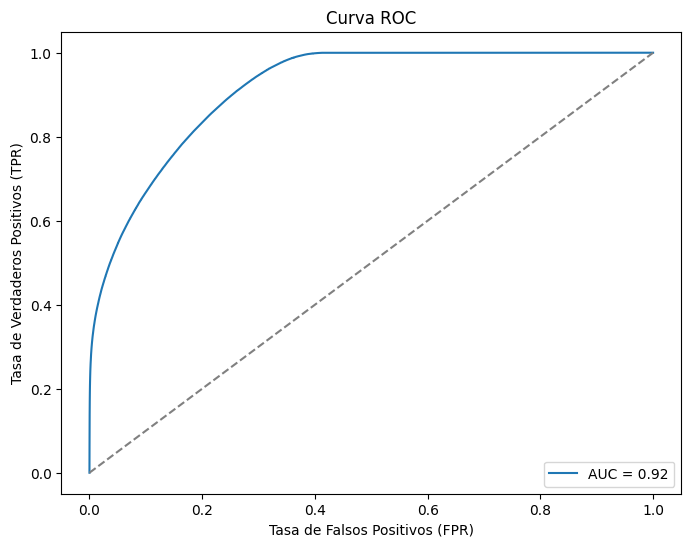

In [4]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


### Análisis del gráfico: Curva ROC (Receiver Operating Characteristic)

La curva ROC presentada muestra el desempeño del modelo LightGBM en la clasificación de la morosidad tributaria. La gráfica evalúa la relación entre la **tasa de verdaderos positivos (TPR)** y la **tasa de falsos positivos (FPR)** a diferentes umbrales de decisión. Un área bajo la curva (AUC) de **0.92** indica que el modelo tiene un excelente rendimiento discriminativo para diferenciar entre contribuyentes morosos y no morosos.

- **Interpretación del AUC**: Un AUC cercano a 1 (en este caso, 0.92) refleja que el modelo predice correctamente los casos de morosidad en la gran mayoría de los escenarios. Esto implica que el modelo es robusto y confiable para el problema en cuestión.
  
- **Forma de la curva**: La curva ROC se aproxima al punto superior izquierdo, lo que sugiere que el modelo logra un buen equilibrio entre la captura de morosos (alta TPR) y la minimización de falsos positivos (baja FPR).

En el contexto de la morosidad tributaria, esto significa que el modelo es eficaz para identificar correctamente a los contribuyentes con alto riesgo de incumplimiento, lo cual es crítico para priorizar acciones preventivas o de recaudación. Sin embargo, se debe complementar este análisis con métricas adicionales como precisión, recall y F1-score, así como evaluar el impacto de posibles falsos positivos en la estrategia de gestión tributaria.

## **Gráfico de Precisión-Recall (Precision-Recall Curve)**
**Propósito:** Evaluar el desempeño del modelo en términos de precisión y sensibilidad (recall) para diferentes umbrales.

**Beneficio:** Es especialmente útil si las clases están desbalanceadas, ya que pone mayor énfasis en los verdaderos positivos.

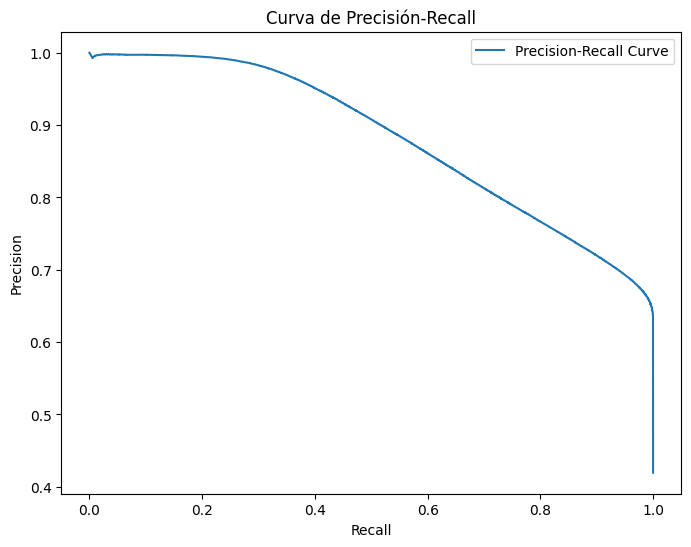

In [5]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall")
plt.legend(loc="upper right")
plt.show()


### Análisis del gráfico: Curva de Precisión-Recall

La curva de **Precisión-Recall** presentada evalúa el rendimiento del modelo LightGBM en términos de la precisión (proporción de predicciones correctas de morosidad sobre todas las predicciones positivas) frente al recall (capacidad de identificar todos los casos de morosidad). Este gráfico es especialmente útil en casos de desequilibrio de clases, como es común en problemas de morosidad tributaria.

- **Forma de la curva**: La precisión comienza alta para valores bajos de recall y decrece a medida que aumenta el recall. Esto indica que el modelo identifica correctamente a los morosos cuando se enfoca en un subconjunto limitado de casos, pero conforme intenta abarcar más casos (mayor recall), la proporción de falsos positivos aumenta, reduciendo la precisión.

- **Interpretación del equilibrio**: El modelo logra un buen compromiso en las primeras regiones de la curva, donde tanto la precisión como el recall son altas (por encima de 0.8). Esto sugiere que el modelo tiene un buen rendimiento para identificar una proporción significativa de morosos sin comprometer demasiado la calidad de las predicciones.

En el contexto de la morosidad tributaria, este gráfico refuerza que el modelo es eficaz para priorizar a los contribuyentes de mayor riesgo, especialmente en situaciones donde es más importante capturar a los morosos reales (alto recall) sin saturar las acciones con falsos positivos (reducción de la precisión). Se recomienda determinar un umbral óptimo en esta curva según los objetivos específicos, como maximizar la recuperación de ingresos o minimizar los costos operativos.

## **Matriz de Confusión con Mapa de Calor**

**Propósito:** Visualizar la matriz de confusión de forma más interpretativa usando un mapa de calor.

**Beneficio:** Facilitar la identificación de aciertos y errores del modelo en las clases predichas.

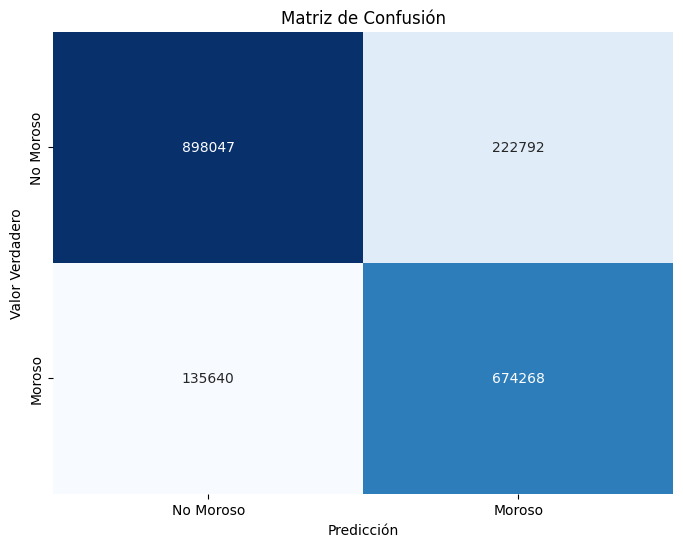

In [6]:
import seaborn as sns
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()


### Análisis del gráfico: Matriz de Confusión

La matriz de confusión presentada muestra los resultados de clasificación del modelo LightGBM en términos de predicciones correctas e incorrectas para el problema de predicción de morosidad tributaria. Cada celda refleja el número de observaciones clasificadas en cada categoría:

- **Verdaderos Negativos (No moroso predicho correctamente):** 898,047
- **Falsos Positivos (No moroso predicho como moroso):** 222,792
- **Falsos Negativos (Moroso predicho como no moroso):** 135,640
- **Verdaderos Positivos (Moroso predicho correctamente):** 674,268

#### Interpretación
- **Eficiencia global:** El modelo tiene un desempeño robusto, logrando una alta proporción de predicciones correctas, especialmente en la clasificación de morosos (674,268). Esto es relevante porque identificar correctamente a los morosos permite focalizar estrategias de cobro.
- **Errores de clasificación:**
  - Los **falsos positivos (222,792)** representan a contribuyentes que no son morosos pero fueron clasificados como tales. Aunque generan costos operativos, pueden aceptarse si los recursos destinados a investigar o notificar a estos contribuyentes son menores que los ingresos recuperados de los verdaderos morosos.
  - Los **falsos negativos (135,640)** son más críticos, ya que representan morosos que no fueron detectados por el modelo. Este es un desafío a abordar si el objetivo es maximizar la recuperación de ingresos.

#### Implicaciones en el contexto tributario
El modelo muestra un equilibrio adecuado entre precisión y recall, pero los falsos negativos deben evaluarse en términos de su impacto económico. Si las pérdidas asociadas a estos son significativas, podría ser necesario ajustar el umbral de decisión del modelo para priorizar la detección de morosos, aunque esto podría aumentar los falsos positivos. Por lo tanto, se recomienda una optimización basada en un análisis de costo-beneficio para definir el nivel de tolerancia a los errores en función de los objetivos estratégicos.

## **Importancia de las Características (Coeficientes)**

**Propósito:** Mostrar gráficamente la importancia de las variables en la predicción de la morosidad basada en los coeficientes del modelo de regresión logística.

**Beneficio:** Ayuda a interpretar el modelo ya identificar las variables más influyentes.

C:\Users\hrqui\AppData\Local\Temp\ipykernel_15080\552896770.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')


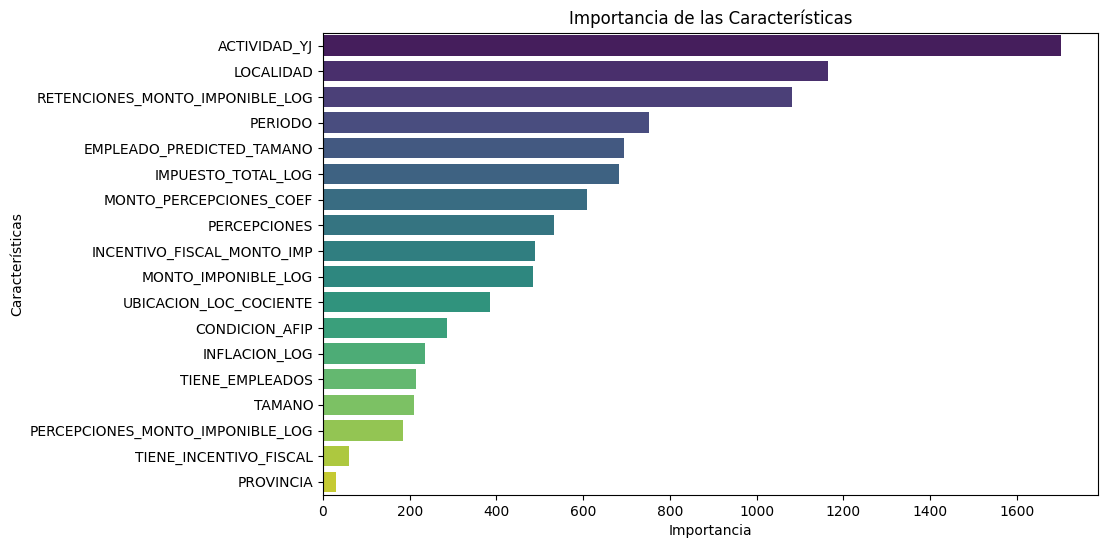

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la importancia de las características desde el modelo
importances = model.feature_importances_

# Crear un DataFrame con las características y su importancia
coef_df = pd.DataFrame({
    'Características': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



### Análisis del gráfico: Importancia de las Características

El gráfico de importancia de características generado por el modelo LightGBM muestra el peso relativo que cada variable tiene en la predicción de la morosidad tributaria. Este análisis permite interpretar qué factores contribuyen más a las decisiones del modelo y brinda insights valiosos sobre las variables más influyentes en el comportamiento de los contribuyentes.

#### Principales hallazgos:
1. **Variables más importantes:**
   - **ACTIVIDAD_YJ**: Esta variable (que posiblemente se refiere a la actividad económica del contribuyente) tiene la mayor influencia en la predicción de la morosidad. Esto sugiere que ciertas actividades económicas presentan un mayor riesgo de incumplimiento tributario.
   - **LOCALIDAD**: La ubicación geográfica del contribuyente también es crítica, indicando que factores locales (infraestructura, acceso a servicios, o características económicas regionales) afectan significativamente el comportamiento de pago.
   - **RETENCIONES_MONTO_IMPONIBLE_LOG**: Los montos asociados a retenciones fiscales son altamente relevantes. Este resultado puede implicar que mayores retenciones podrían estar asociadas con un mayor riesgo de morosidad, dependiendo de las circunstancias.

2. **Variables moderadamente importantes:**
   - **PERIODO**: Sugeriría que existen patrones temporales en la morosidad, como estacionalidad o impacto de cambios normativos.
   - **EMPLEADO_PREDICTED_TAMANO**: El tamaño de la empresa o cantidad de empleados parece influir, reflejando que las empresas más grandes o pequeñas pueden tener diferentes comportamientos de pago.
   - **IMPUESTO_TOTAL_LOG** y **MONTO_PERCEPCIONES_COEF**: Variables relacionadas con las obligaciones fiscales totales y percepciones también tienen un peso significativo, lo que indica que los montos adeudados son factores clave en la predicción.

3. **Variables de menor impacto:**
   - **PROVINCIA** y **TIENE_INCENTIVO_FISCAL**: Aunque estas variables están incluidas, su impacto es reducido, lo que podría implicar que otros factores regionales o relacionados con incentivos fiscales tienen menor relevancia en la morosidad.

#### Implicaciones para el análisis de morosidad tributaria:
Este gráfico ofrece insights clave para priorizar políticas fiscales y acciones de gestión tributaria. Por ejemplo:
- La alta importancia de **ACTIVIDAD_YJ** sugiere que es crucial diseñar estrategias específicas para sectores económicos con mayor riesgo de incumplimiento.
- La relevancia de **LOCALIDAD** y otras variables geográficas apunta a la necesidad de adoptar enfoques regionales personalizados.
- El modelo podría ser usado para identificar contribuyentes de alto riesgo según las características destacadas, optimizando el uso de recursos en la recaudación.

Este análisis también brinda una guía para refinar futuras versiones del modelo, asegurándose de incluir datos de calidad sobre las características más influyentes y posiblemente explorar más a fondo las variables de menor impacto para comprender su rol.

## **Distribución de las Probabilidades Predichas**

**Propósito:** Mostrar la distribución de las probabilidades predichas para cada clase.

**Beneficio:** Permite analizar cómo el modelo clasifica los datos y si existe algún solapamiento importante entre las clases.

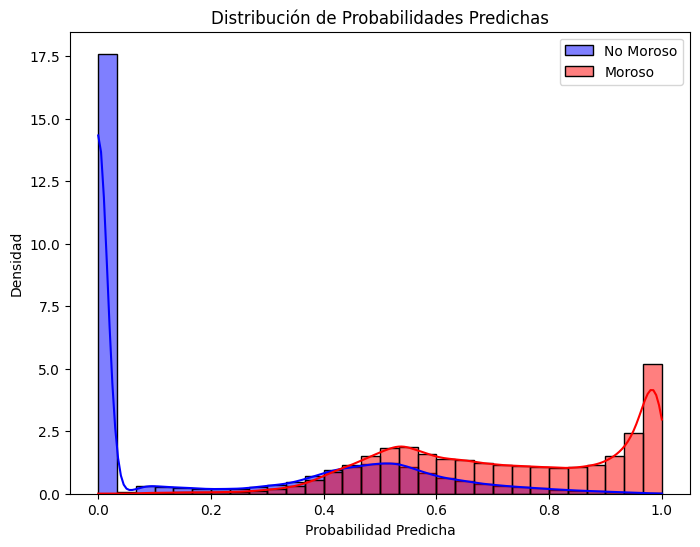

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], label='No Moroso', color='blue', kde=True, stat='density', bins=30)
sns.histplot(y_pred_proba[y_test == 1], label='Moroso', color='red', kde=True, stat='density', bins=30)
plt.title("Distribución de Probabilidades Predichas")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Densidad")
plt.legend()
plt.show()


### Análisis del gráfico: Distribución de Probabilidades Predichas

El gráfico muestra la distribución de las probabilidades predichas por el modelo LightGBM para las dos clases: **No Moroso (azul)** y **Moroso (rojo)**. Este análisis permite evaluar cómo el modelo asigna las probabilidades y qué tan bien separa ambas clases.

#### Interpretación de las distribuciones:
1. **Clase No Moroso (azul):**
   - La mayoría de los contribuyentes clasificados como "No Morosos" tienen probabilidades predichas cercanas a **0**, lo que indica una alta confianza del modelo en esta clasificación.
   - Existe una pequeña superposición con probabilidades intermedias (0.4 - 0.6), lo que sugiere que algunos contribuyentes de esta clase son difíciles de separar con claridad.

2. **Clase Moroso (rojo):**
   - Los contribuyentes morosos presentan una concentración alta de probabilidades cerca de **1**, indicando que el modelo también tiene alta confianza en estas predicciones.
   - Al igual que la clase "No Moroso", hay una superposición en el rango intermedio de probabilidades (0.4 - 0.6), lo que indica que ciertos casos de morosidad son ambiguos.

3. **Zona de superposición:**
   - En el rango de **0.4 a 0.6**, hay contribuyentes de ambas clases, lo que representa los casos más desafiantes para el modelo. Estas probabilidades intermedias reflejan incertidumbre en la predicción y podrían estar asociadas a contribuyentes con características similares entre las dos clases.

#### Implicaciones para la predicción de morosidad tributaria:
- **Buena separación general:** El modelo logra una clara diferenciación entre las dos clases, lo que respalda su capacidad para discriminar entre morosos y no morosos. Esto es visible en las concentraciones altas de probabilidades cerca de 0 y 1.
- **Casos ambiguos:** Los contribuyentes con probabilidades intermedias (zona de superposición) podrían requerir un análisis adicional. Por ejemplo:
  - Implementar reglas de negocio para decidir cómo tratarlos (e.g., notificaciones preventivas para quienes tienen una probabilidad superior a 0.5).
  - Ajustar el umbral de decisión según el impacto económico de los falsos positivos y falsos negativos.
  
En el contexto tributario, este análisis puede ayudar a priorizar las acciones en función del riesgo, enfocando esfuerzos en los contribuyentes con mayor probabilidad de ser morosos, mientras se evalúan medidas menos costosas para los casos con predicciones menos claras.